# Combined LSTM-CNN Models

## Intuition: Why CNNs and LSTMs?

Before starting, let's give a brief introduction to these networks along with a short analysis of why I thought they would benefit my sentiment analysis task.
## CNNs

Convolutional Neural Networks (CNNs) are networks initially created for image-related tasks that can learn to capture specific features regardless of locality.

For a more concrete example of that, imagine we use CNNs to distinguish pictures of Cars vs. pictures of Dogs. Since CNNs learn to capture features regardless of where these might be, the CNN will learn that cars have wheels, and every time it sees a wheel, regardless of where it is on the picture, that feature will activate.

In our particular case, it could capture a negative phrase such as "don't like" regardless of where it happens in the tweet.

*     I don't like watching those types of films
*     That's the one thing I really don't like.
*     I saw the movie, and I don't like how it ended.

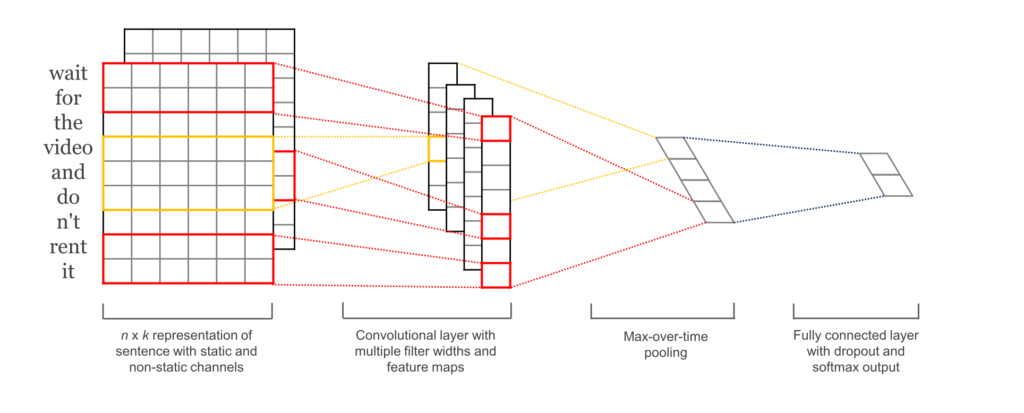


## LSTMs

Long-Term Short Term Memory (LSTMs) are a type of network that has a memory that "remembers" previous data from the input and makes decisions based on that knowledge. These networks are more directly suited for written data inputs, since each word in a sentence has meaning based on the surrounding words (previous and upcoming words).

In our particular case, it is possible that an LSTM could allow us to capture changing sentiment in a tweet. For example, a sentence such as: At first I loved it, but then I ended up hating it. has words with conflicting sentiments that would end-up confusing a simple Feed-Forward network. The LSTM, on the other hand, could learn that sentiments expressed towards the end of a sentence mean more than those expressed at the start.



## CNN-LSTM Model

The first model I tried was the CNN-LSTM Model. Our CNN-LSTM model combination consists of an initial convolution
layer which will receive word embeddings as input. Its output will then be pooled to a smaller dimension which is then fed into an LSTM layer. The intuition behind this model is that the convolution layer will extract local features and the LSTM layer will then be able to use the ordering of said features to learn about the input’s text ordering. In practice, this model is not as powerful as our other LSTM-CNN model proposed.

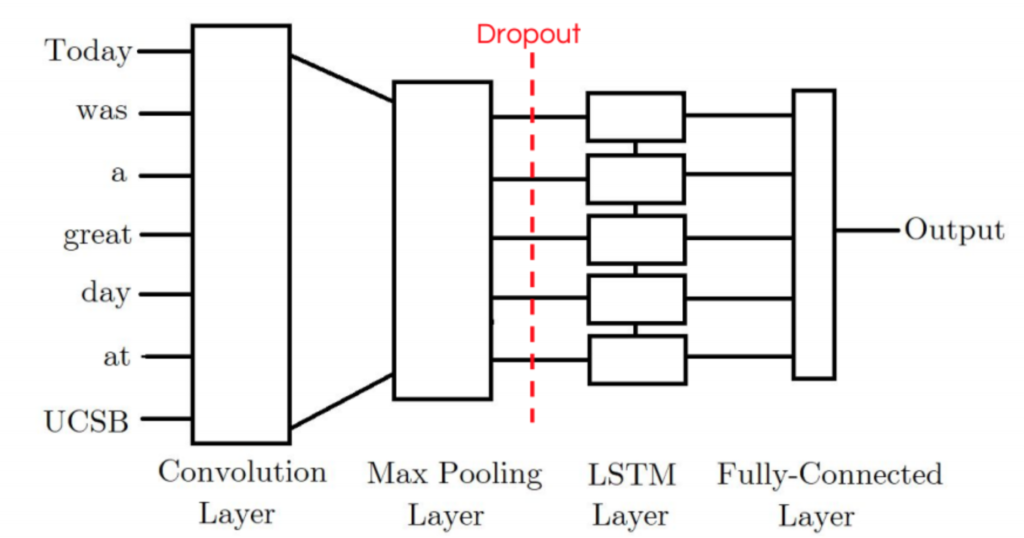

## LSTM-CNN Model

Our CNN-LSTM model consists of an initial LSTM layer which will receive word embeddings for each token in the tweet as inputs. The intuition is that its output tokens will store information not only of the initial token, but also any previous tokens; In other words, the LSTM layer is generating a new encoding for the original input. The output of the LSTM layer is then fed into a convolution layer which we expect will extract local features. Finally the convolution layer’s output will be pooled to a smaller dimension and ultimately outputted as either a positive or negative label.

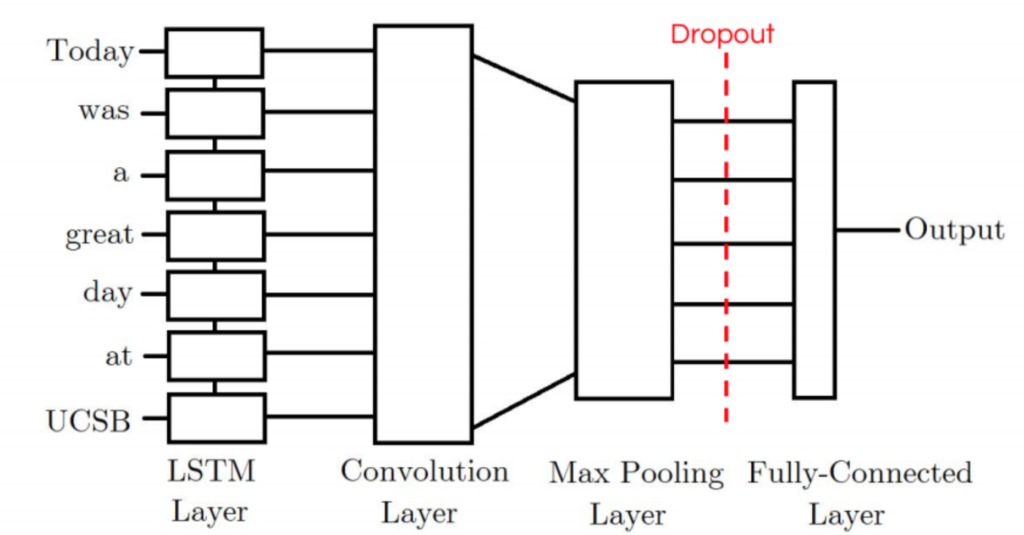

Source
> http://konukoii.com/blog/2018/02/19/twitter-sentiment-analysis-using-combined-lstm-cnn-models/

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from nltk.tokenize import TweetTokenizer
import datetime
import lightgbm as lgb
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
pd.set_option('max_colwidth',400)

In [ ]:
train = pd.read_csv('../input/movie-review-sentiment-analysis-kernels-only/train.tsv', sep="\t")
test = pd.read_csv('../input/movie-review-sentiment-analysis-kernels-only/test.tsv', sep="\t")
sub = pd.read_csv('../input/movie-review-sentiment-analysis-kernels-only/sampleSubmission.csv', sep=",")

In [ ]:
train.head(10)

In [ ]:
train.loc[train.SentenceId == 2]

In [ ]:
print('Average count of phrases per sentence in train is {0:.0f}.'.format(train.groupby('SentenceId')['Phrase'].count().mean()))
print('Average count of phrases per sentence in test is {0:.0f}.'.format(test.groupby('SentenceId')['Phrase'].count().mean()))

In [ ]:
print('Number of phrases in train: {}. Number of sentences in train: {}.'.format(train.shape[0], len(train.SentenceId.unique())))
print('Number of phrases in test: {}. Number of sentences in test: {}.'.format(test.shape[0], len(test.SentenceId.unique())))

In [ ]:
print('Average word length of phrases in train is {0:.0f}.'.format(np.mean(train['Phrase'].apply(lambda x: len(x.split())))))
print('Average word length of phrases in test is {0:.0f}.'.format(np.mean(test['Phrase'].apply(lambda x: len(x.split())))))

Let's see for example most common trigrams for positive phrases

In [ ]:
text = ' '.join(train.loc[train.SentenceId == 4, 'Phrase'].values)
text = [i for i in ngrams(text.split(), 3)]

In [ ]:
Counter(text).most_common(20)

Well... I don't think that they are really positive.

### Thoughts on feature processing and engineering

So, we have only phrases as data. And a phrase can contain a single word. And one punctuation mark can cause phrase to receive a different sentiment. Also assigned sentiments can be strange. This means several things:
- using stopwords can be a bad idea, especially when phrases contain one single stopword;
- puntuation could be important, so it should be used;
- ngrams are necessary to get the most info from data;
- using features like word count or sentence length won't be useful;

In [ ]:
tokenizer = TweetTokenizer()

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), tokenizer=tokenizer.tokenize)
full_text = list(train['Phrase'].values) + list(test['Phrase'].values)
vectorizer.fit(full_text)
train_vectorized = vectorizer.transform(train['Phrase'])
test_vectorized = vectorizer.transform(test['Phrase'])

In [ ]:
y = train['Sentiment']

In [ ]:
logreg = LogisticRegression()
ovr = OneVsRestClassifier(logreg)

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D, GRU, CuDNNGRU, CuDNNLSTM, BatchNormalization
from keras.layers import Bidirectional, GlobalMaxPool1D, MaxPooling1D, Add, Flatten
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate, SpatialDropout1D
from keras.models import Model, load_model
from keras import initializers, regularizers, constraints, optimizers, layers, callbacks
from keras import backend as K
from keras.engine import InputSpec, Layer
from keras.optimizers import Adam

from keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping

In [ ]:
tk = Tokenizer(lower = True, filters='')
tk.fit_on_texts(full_text)

In [ ]:
train_tokenized = tk.texts_to_sequences(train['Phrase'])
test_tokenized = tk.texts_to_sequences(test['Phrase'])

In [ ]:
max_len = 50
X_train = pad_sequences(train_tokenized, maxlen = max_len)
X_test = pad_sequences(test_tokenized, maxlen = max_len)

In [ ]:
embedding_path = "../input/fasttext-crawl-300d-2m/crawl-300d-2M.vec"

In [ ]:
embed_size = 300
max_features = 20000

In [ ]:
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embedding_index = dict(get_coefs(*o.strip().split(" ")) for o in open(embedding_path))

word_index = tk.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.zeros((nb_words + 1, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [ ]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse=False)
y_ohe = ohe.fit_transform(y.values.reshape(-1, 1))

In [ ]:
file_path = "best_model.hdf5"
check_point = ModelCheckpoint(file_path, monitor = "val_loss", verbose = 1,
                              save_best_only = True, mode = "min")
early_stop = EarlyStopping(monitor = "val_loss", mode = "min", patience = 3)

def build_model(lr = 0.0, lr_d = 0.0, units = 0, dr = 0.0):
    inp = Input(shape = (max_len,))
    x = Embedding(19479, embed_size, weights = [embedding_matrix], trainable = False)(inp)
    x1 = SpatialDropout1D(dr)(x)

    x_gru = Bidirectional(CuDNNGRU(units, return_sequences = True))(x1)
    x1 = Conv1D(32, kernel_size=3, padding='valid', kernel_initializer='he_uniform')(x_gru)
    avg_pool1_gru = GlobalAveragePooling1D()(x1)
    max_pool1_gru = GlobalMaxPooling1D()(x1)
    
    x3 = Conv1D(32, kernel_size=2, padding='valid', kernel_initializer='he_uniform')(x_gru)
    avg_pool3_gru = GlobalAveragePooling1D()(x3)
    max_pool3_gru = GlobalMaxPooling1D()(x3)
    
    x_lstm = Bidirectional(CuDNNLSTM(units, return_sequences = True))(x1)
    x1 = Conv1D(32, kernel_size=3, padding='valid', kernel_initializer='he_uniform')(x_lstm)
    avg_pool1_lstm = GlobalAveragePooling1D()(x1)
    max_pool1_lstm = GlobalMaxPooling1D()(x1)
    
    x3 = Conv1D(32, kernel_size=2, padding='valid', kernel_initializer='he_uniform')(x_lstm)
    avg_pool3_lstm = GlobalAveragePooling1D()(x3)
    max_pool3_lstm = GlobalMaxPooling1D()(x3)
    
    
    x = concatenate([avg_pool1_gru, max_pool1_gru, avg_pool3_gru, max_pool3_gru,
                    avg_pool1_lstm, max_pool1_lstm, avg_pool3_lstm, max_pool3_lstm])
    x = BatchNormalization()(x)
    x = Dropout(0.2)(Dense(128,activation='relu') (x))
    x = BatchNormalization()(x)
    x = Dropout(0.2)(Dense(100,activation='relu') (x))
    x = Dense(5, activation = "sigmoid")(x)
    model = Model(inputs = inp, outputs = x)
    model.compile(loss = "binary_crossentropy", optimizer = Adam(lr = lr, decay = lr_d), metrics = ["accuracy"])
    history = model.fit(X_train, y_ohe, batch_size = 128, epochs = 15, validation_split=0.1, 
                        verbose = 1, callbacks = [check_point, early_stop])
    model = load_model(file_path)
    return model

In [ ]:
model = build_model(lr = 1e-4, lr_d = 0, units = 128, dr = 0.5)

In [ ]:
pred = model.predict(X_test, batch_size = 1024)

In [ ]:
predictions = np.round(np.argmax(pred, axis=1)).astype(int)
# for blending if necessary.
#(ovr.predict(test_vectorized) + svc.predict(test_vectorized) + np.round(np.argmax(pred, axis=1)).astype(int)) / 3
sub['Sentiment'] = predictions
sub.to_csv("blend.csv", index=False)